# Model MobileNetV2 untuk Capstone Project: **Recyclepedia**
Datasets : https://drive.google.com/drive/folders/1BkxkYTDxBIg4mHoA8BkM4UV0ff-R8kmt?usp=drive_link

Akurasi : 95%

## **Pre - Processing Data**

Import Library

In [1]:
import os
import shutil
from shutil import copyfile
from sklearn.model_selection import train_test_split
import gdown
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


Import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Garbage classification')

In [4]:
# Path ke dataset di Google Drive
base_dir = ('/content/drive/MyDrive/Garbage classification')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Pastikan direktori untuk setiap kelas
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)


In [5]:
import os

# Tampilkan daftar file di direktori ekstraksi
base_dir = ('/content/drive/MyDrive/Garbage classification')
os.listdir(base_dir)


['paper',
 'cardboard',
 'glass',
 'plastic',
 'metal',
 'train',
 'test',
 'validation',
 'best_model_mobilenetv2.h5',
 '.ipynb_checkpoints',
 'Untitled.jpeg',
 'training_history.pkl',
 'model_mobilenetv2.h5',
 'model_mobilenetv2.keras',
 'best_model_mobilenetv2.keras',
 '1.tfjs, acc 89.zip']

##**Train Test Validation**

####**Membagi Dataset Menjadi Train, Validation, dan Test**

In [37]:
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split

def split_data(source_dir, train_dir, val_dir, test_dir, train_split=0.6, val_split=0.2, test_split=0.2):
    filenames = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    train_filenames, temp_filenames = train_test_split(filenames, test_size=1-train_split, random_state=42)
    val_filenames, test_filenames = train_test_split(temp_filenames, test_size=test_split/(test_split + val_split), random_state=42)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for filename in train_filenames:
        src = os.path.join(source_dir, filename)
        dest = os.path.join(train_dir, filename)
        copyfile(src, dest)

    for filename in val_filenames:
        src = os.path.join(source_dir, filename)
        dest = os.path.join(val_dir, filename)
        copyfile(src, dest)

    for filename in test_filenames:
        src = os.path.join(source_dir, filename)
        dest = os.path.join(test_dir, filename)
        copyfile(src, dest)

for class_name in classes:
    source_dir = os.path.join(base_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(validation_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    split_data(source_dir, train_class_dir, val_class_dir, test_class_dir)

#### Definisikan path


In [38]:
train_dir = ('/content/drive/MyDrive/Garbage classification/train')
val_dir = ('/content/drive/MyDrive/Garbage classification/validation')
test_dir = ('/content/drive/MyDrive/Garbage classification/test')

In [39]:
#cardboard, glass, metal, paper, plastic
import os
folder_path = ('/content/drive/MyDrive/Garbage classification/train/cardboard')
folder_path = ('/content/drive/MyDrive/Garbage classification/train/glass')
folder_path = ('/content/drive/MyDrive/Garbage classification/train/metal')
folder_path = ('/content/drive/MyDrive/Garbage classification/train/paper')
folder_path = ('/content/drive/MyDrive/Garbage classification/train/plastic')
test = os.listdir(folder_path)
# for fichier in test:
#     if not(fichier.endswith(".jpg")):
#         os.remove(os.path.join(folder_path, fichier))

In [40]:
#cek label
from pathlib import Path
train_dir = Path('/content/drive/MyDrive/Garbage classification/train')
test_dir = Path('/content/drive/MyDrive/Garbage classification/test')
val_dir = Path('/content/drive/MyDrive/Garbage classification/validation')

# Mendapatkan daftar filepaths dan labels untuk dataset dan data uji
# Get filepaths and labels
filepaths = list(train_dir.glob(r'**/*.jpg')) + list(train_dir.glob(r'**/*.JPG')) + list(train_dir.glob(r'**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Get filepaths and labels data validation
filepaths_val = list(val_dir.glob(r'**/*.jpg')) + list(val_dir.glob(r'**/*.JPG')) + list(val_dir.glob(r'**/*.jpeg'))
labels_val = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_val))

# Get filepaths and labels data testing
filepaths_test = list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.JPG')) + list(test_dir.glob(r'**/*.jpeg'))
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_test))

## **Augmentasi dan Pre-processing Gambar**

####Menampilkan Gambar dari dataset train

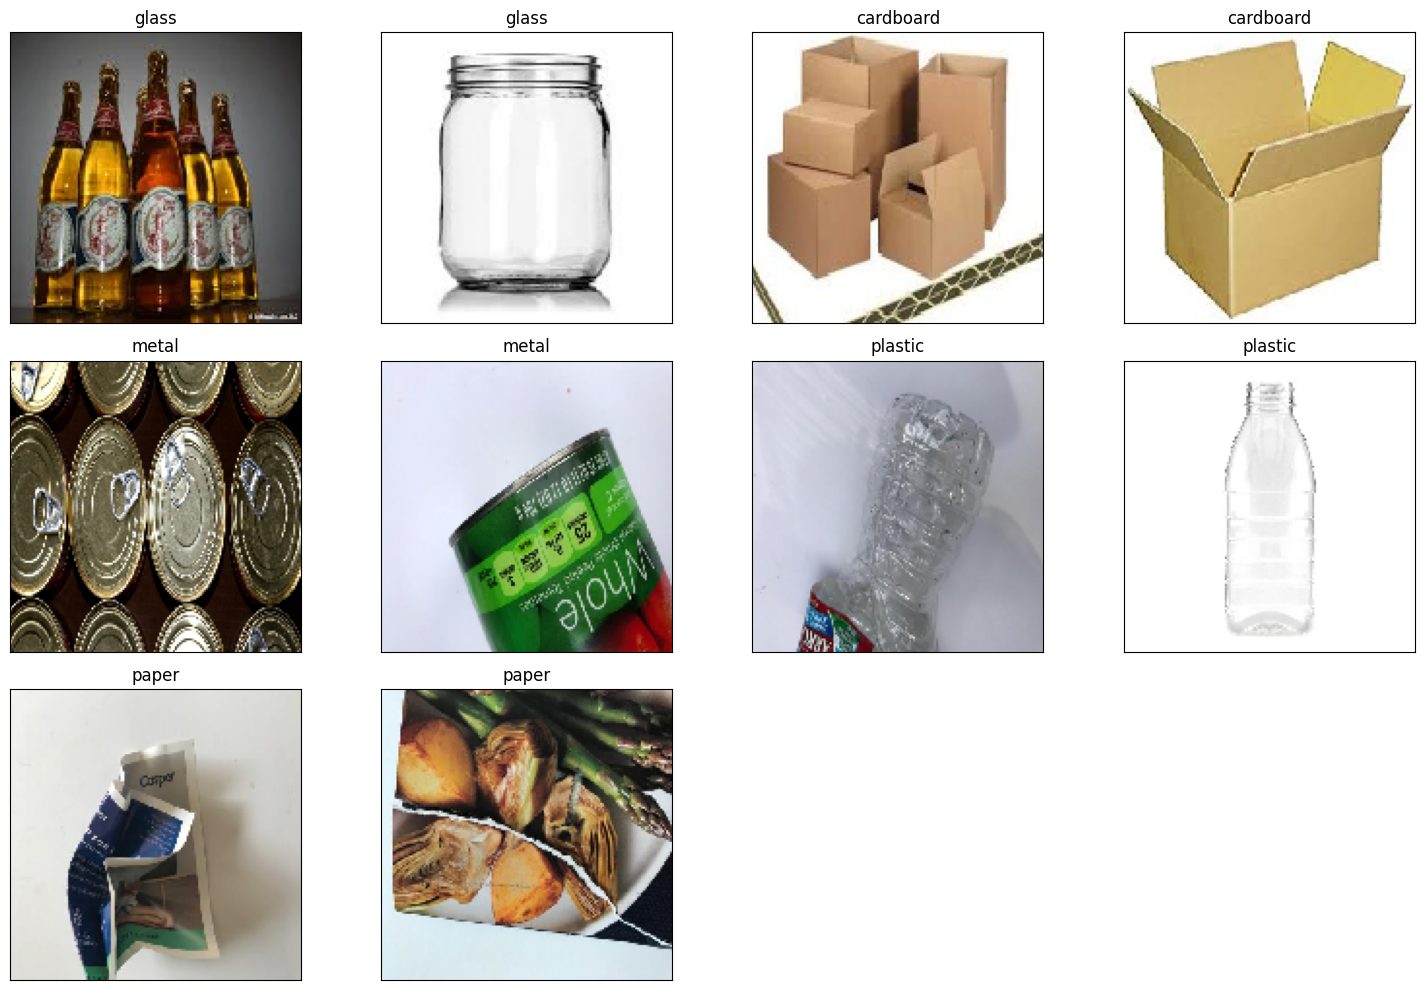

In [41]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path ke dataset
train_dir = '/content/drive/MyDrive/Garbage classification/train'

# Fungsi untuk menampilkan gambar dari setiap label
def display_sample_images(train_dir, num_images=12):
    class_names = os.listdir(train_dir)
    num_classes = len(class_names)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols  # Menghitung jumlah baris yang diperlukan

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})
    axes = axes.flatten()

    img_idx = 0
    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        img_files = os.listdir(class_dir)
        num_samples = min(len(img_files), num_images // num_classes)

        for img_file in random.sample(img_files, num_samples):
            img_path = os.path.join(class_dir, img_file)
            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0

            ax = axes[img_idx]
            ax.imshow(img_array)
            ax.set_title(class_name)
            img_idx += 1
            if img_idx >= num_images:
                break
        if img_idx >= num_images:
            break

    # Jika ada subplot yang kosong, hapus subplot tersebut
    for j in range(img_idx, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan gambar
display_sample_images(train_dir, num_images=12)


####**Augmentasi ImageDataGenerator**

In [42]:
import pandas as pd
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
train_dir = Path('/content/drive/MyDrive/Garbage classification/train')
val_dir = Path('/content/drive/MyDrive/Garbage classification/validation')
test_dir = Path('/content/drive/MyDrive/Garbage classification/test')

def create_dataframe(directory):
    filepaths = list(directory.glob('*/*.jpg'))  # Adjust the pattern based on your file types
    labels = [path.parent.name for path in filepaths]
    return pd.DataFrame({'Filepath': [str(path) for path in filepaths], 'Label': labels})

# Create DataFrames
train_df = create_dataframe(train_dir)
val_df = create_dataframe(val_dir)
test_df = create_dataframe(test_dir)

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# Data augmentation for validation and test set
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_data = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(240, 240),
    batch_size=16,
    shuffle=True,
    class_mode='categorical'
)

validasi_data = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(240, 240),
    batch_size=16,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(240, 240),
    batch_size=16,
    shuffle=False,
    class_mode='categorical'
)


Found 1944 validated image filenames belonging to 5 classes.
Found 822 validated image filenames belonging to 5 classes.
Found 823 validated image filenames belonging to 5 classes.


#### Menampilkan Gambar yang sudah di Augmentasi

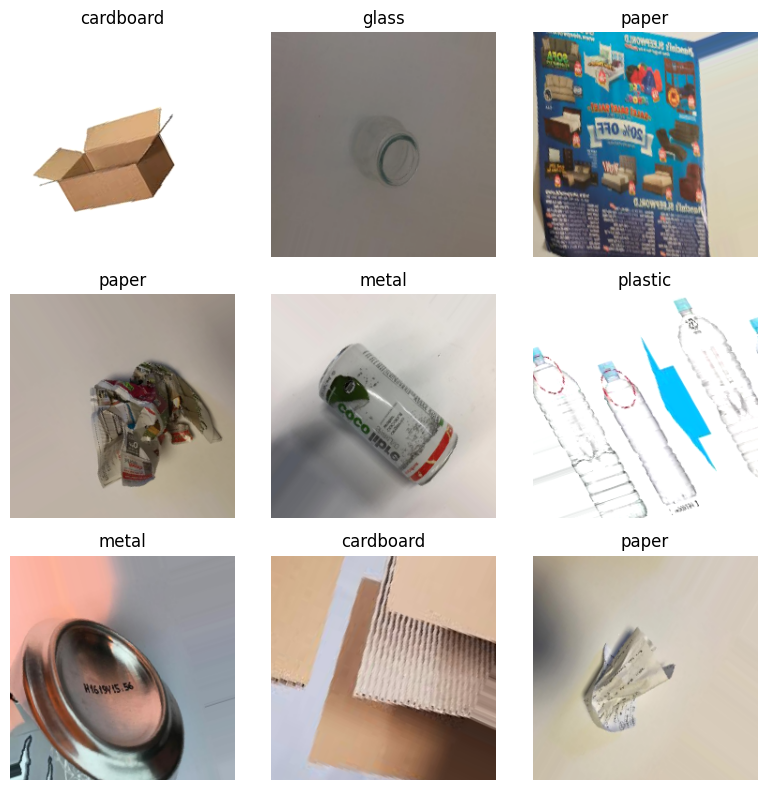

In [43]:
import matplotlib.pyplot as plt

# Ambil satu batch gambar dari generator
augmented_images, labels = next(train_data)

# Menampilkan beberapa contoh gambar yang telah diaugmentasi
num_images = 9
plt.figure(figsize=(8, 8))

# Generate a batch of augmented images
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    label_index = labels[i].argmax()  # Get the index of the maximum value (1) in the one-hot encoded label
    label_name = list(train_data.class_indices.keys())[label_index]  # Get the class name using the index
    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


## **Membangun Model | MobileNetV2| CNN**

In [45]:
from keras import Model, Input
input_shape = (224,224,3)
model_input = Input(shape=input_shape)

In [46]:
import os
import pickle
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import numpy as np

# Define the model using Sequential API
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze the base model

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define custom callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        if logs.get('loss') < 0.05 and logs.get('val_accuracy') > 0.96:
            print("\nStopped, Akurasi mencapai 96%")
            self.model.stop_training = True

# Define callbacks
checkpoint_path = '/content/drive/MyDrive/Garbage classification/H5/best_model_mobilenetv2.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      mode='min',
                                      verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
callbacks = [checkpoint_callback, early_stopping, reduce_lr, myCallback()]

# Train the model
history = model.fit(
    train_data,
    epochs=50,
    validation_data=validasi_data,
    callbacks=callbacks,
    verbose=1,
)

# Unfreeze some layers of the base model
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training the model with unfrozen base model layers
fine_tune_history = model.fit(
    train_data,
    epochs=50,
    validation_data=validasi_data,
    callbacks=callbacks,
    verbose=1,
)

# Save training history
history_path = '/content/drive/MyDrive/Garbage classification/H5/fine_tune_training_history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(fine_tune_history.history, f)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model_save_path = '/content/drive/MyDrive/Garbage classification/H5/model_mobilenetv2_fine_tuned.h5'
model.save(model_save_path)

Epoch 1/50
122/122 [==============================] - ETA: 0s - loss: 3.0410 - accuracy: 0.4830
Epoch 1: val_loss improved from inf to 2.35336, saving model to /content/drive/MyDrive/Garbage classification/H5/best_model_mobilenetv2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


122/122 [==============================] - 166s 1s/step - loss: 3.0410 - accuracy: 0.4830 - val_loss: 2.3534 - val_accuracy: 0.8224 - lr: 1.0000e-04
Epoch 2/50
122/122 [==============================] - ETA: 0s - loss: 2.5459 - accuracy: 0.7011
Epoch 2: val_loss improved from 2.35336 to 2.15999, saving model to /content/drive/MyDrive/Garbage classification/H5/best_model_mobilenetv2.h5
122/122 [==============================] - 168s 1s/step - loss: 2.5459 - accuracy: 0.7011 - val_loss: 2.1600 - val_accuracy: 0.8601 - lr: 1.0000e-04
Epoch 3/50
122/122 [==============================] - ETA: 0s - loss: 2.3722 - accuracy: 0.7510
Epoch 3: val_loss improved from 2.15999 to 2.09369, saving model to /content/drive/MyDrive/Garbage classification/H5/best_model_mobilenetv2.h5
122/122 [==============================] - 162s 1s/step - loss: 2.3722 - accuracy: 0.7510 - val_loss: 2.0937 - val_accuracy: 0.8662 - lr: 1.0000e-04
Epoch 4/50
122/122 [==============================] - ETA: 0s - loss: 2.233

In [ ]:
import os
import pickle
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np


# Define the model using Sequential API
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 220, 3))
base_model.trainable = False  # Freeze the base model

model = tf.keras.models.Sequential([
    base_model,
    # tf.keras.layers.Dropout(0.2)
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Flatten()
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define custom callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        if logs.get('loss') < 0.05 and logs.get('val_accuracy') > 0.96:
            print("\nStopped, Akurasi mencapai 96%")
            self.model.stop_training = True

# Define callbacks
checkpoint_path = '/content/drive/MyDrive/Garbage classification/H5/best_model_mobilenetv2.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      mode='min',
                                      verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
callbacks = [checkpoint_callback, early_stopping, reduce_lr, myCallback()]

# Train the model
history = model.fit(
    train_data,
    epochs=50,
    validation_data=validasi_data,
    callbacks=callbacks,
    verbose=1,
)

# Save training history
history_path = '/content/drive/MyDrive/Garbage classification/H5/training_history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model_save_path = '/content/drive/MyDrive/Garbage classification/H5/model_mobilenetv2.h5'
model.save(model_save_path)


Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 3.7870 - accuracy: 0.1980
Epoch 1: val_loss improved from inf to 3.31501, saving model to /content/drive/MyDrive/Garbage classification/H5/best_model_mobilenetv2.h5
77/77 [==============================] - 108s 1s/step - loss: 3.7870 - accuracy: 0.1980 - val_loss: 3.3150 - val_accuracy: 0.3650 - lr: 1.0000e-05
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 3.5656 - accuracy: 0.2535
Epoch 2: val_loss improved from 3.31501 to 3.17657, saving model to /content/drive/MyDrive/Garbage classification/H5/best_model_mobilenetv2.h5
77/77 [==============================] - 128s 2s/step - loss: 3.5656 - accuracy: 0.2535 - val_loss: 3.1766 - val_accuracy: 0.5100 - lr: 1.0000e-05
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 3.3331 - accuracy: 0.3447
Epoch 3: val_loss improved from 3.17657 to 3.06705, saving model to /content/drive/MyDrive/Garbage classification/H5/best_model_mobilenetv2.h5

#### Plot Model

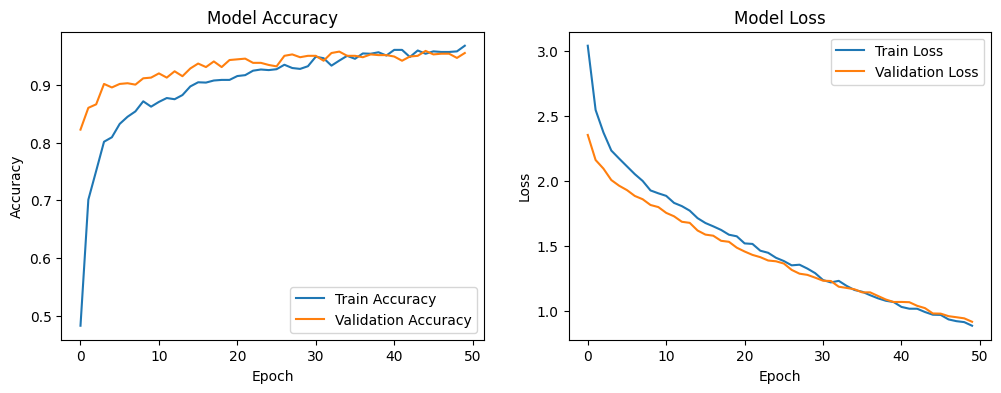

In [47]:
# Plotting the accuracy and loss

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)

##**Evaluasi Model**

Periksa bentuk data yang dihasilkan oleh generator

In [55]:
# Periksa jumlah kelas dalam train, validation, dan test generator
print(f"Number of classes in train data: {len(train_data.class_indices)}")
print(f"Number of classes in validation data: {len(validasi_data.class_indices)}")
print(f"Number of classes in test data: {len(test_data.class_indices)}")

# Ambil satu batch dari train generator dan periksa bentuknya
sample_batch = next(train_data)
print(f"Shape of image batch: {sample_batch[0].shape}")
print(f"Shape of label batch: {sample_batch[1].shape}")

# Ambil satu batch dari test generator dan periksa bentuknya
sample_batch_test = next(test_data)
print(f"Shape of image batch (test): {sample_batch_test[0].shape}")
print(f"Shape of label batch (test): {sample_batch_test[1].shape}")


Number of classes in train data: 5
Number of classes in validation data: 5
Number of classes in test data: 5
Shape of image batch: (16, 240, 240, 3)
Shape of label batch: (16, 5)
Shape of image batch (test): (16, 240, 240, 3)
Shape of label batch (test): (16, 5)


####**Classication Report**

In [56]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy}")

# Generate classification report
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

52/52 [==============================] - 40s 771ms/step - loss: 0.9078 - accuracy: 0.9514
Test Accuracy: 0.9513972997665405
52/52 [==============================] - 51s 921ms/step
              precision    recall  f1-score   support

   cardboard       0.99      0.96      0.98       158
       glass       0.94      0.90      0.92       168
       metal       0.96      0.95      0.96       169
       paper       0.95      0.98      0.97       157
     plastic       0.91      0.97      0.94       171

    accuracy                           0.95       823
   macro avg       0.95      0.95      0.95       823
weighted avg       0.95      0.95      0.95       823



####**Confusion Matrix**

52/52 [==============================] - 36s 680ms/step


<Figure size 700x700 with 0 Axes>

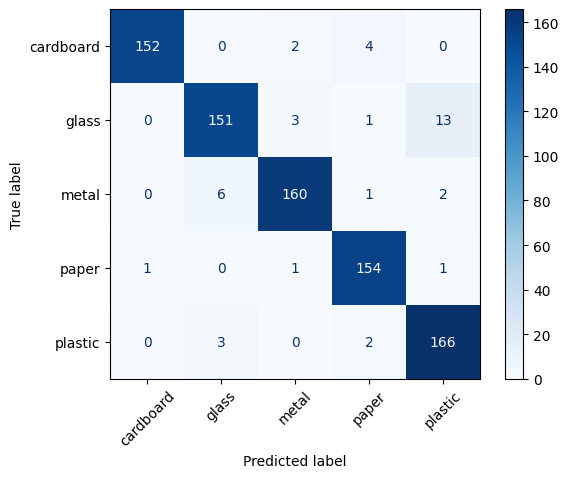

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pastikan model telah diinisialisasi dan dilatih
# test_data sudah diinisialisasi sebelumnya

# Lakukan prediksi pada data pengujian
test_data.reset()  # Reset the test_data to make predictions from the start
predictions = model.predict(test_data, steps=test_data.samples // test_data.batch_size + 1, verbose=1)

# Ambil label sebenarnya dari generator
true_labels = test_data.classes

# Ambil label prediksi
predicted_labels = np.argmax(predictions, axis=1)

# Buat confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(test_data.class_indices.keys()))

# Plot confusion matrix
plt.figure(figsize=(7,7))
cmd.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()


## **Testing Model**

###**Prediksi menggunakan test_dir**

52/52 [==============================] - 35s 663ms/step


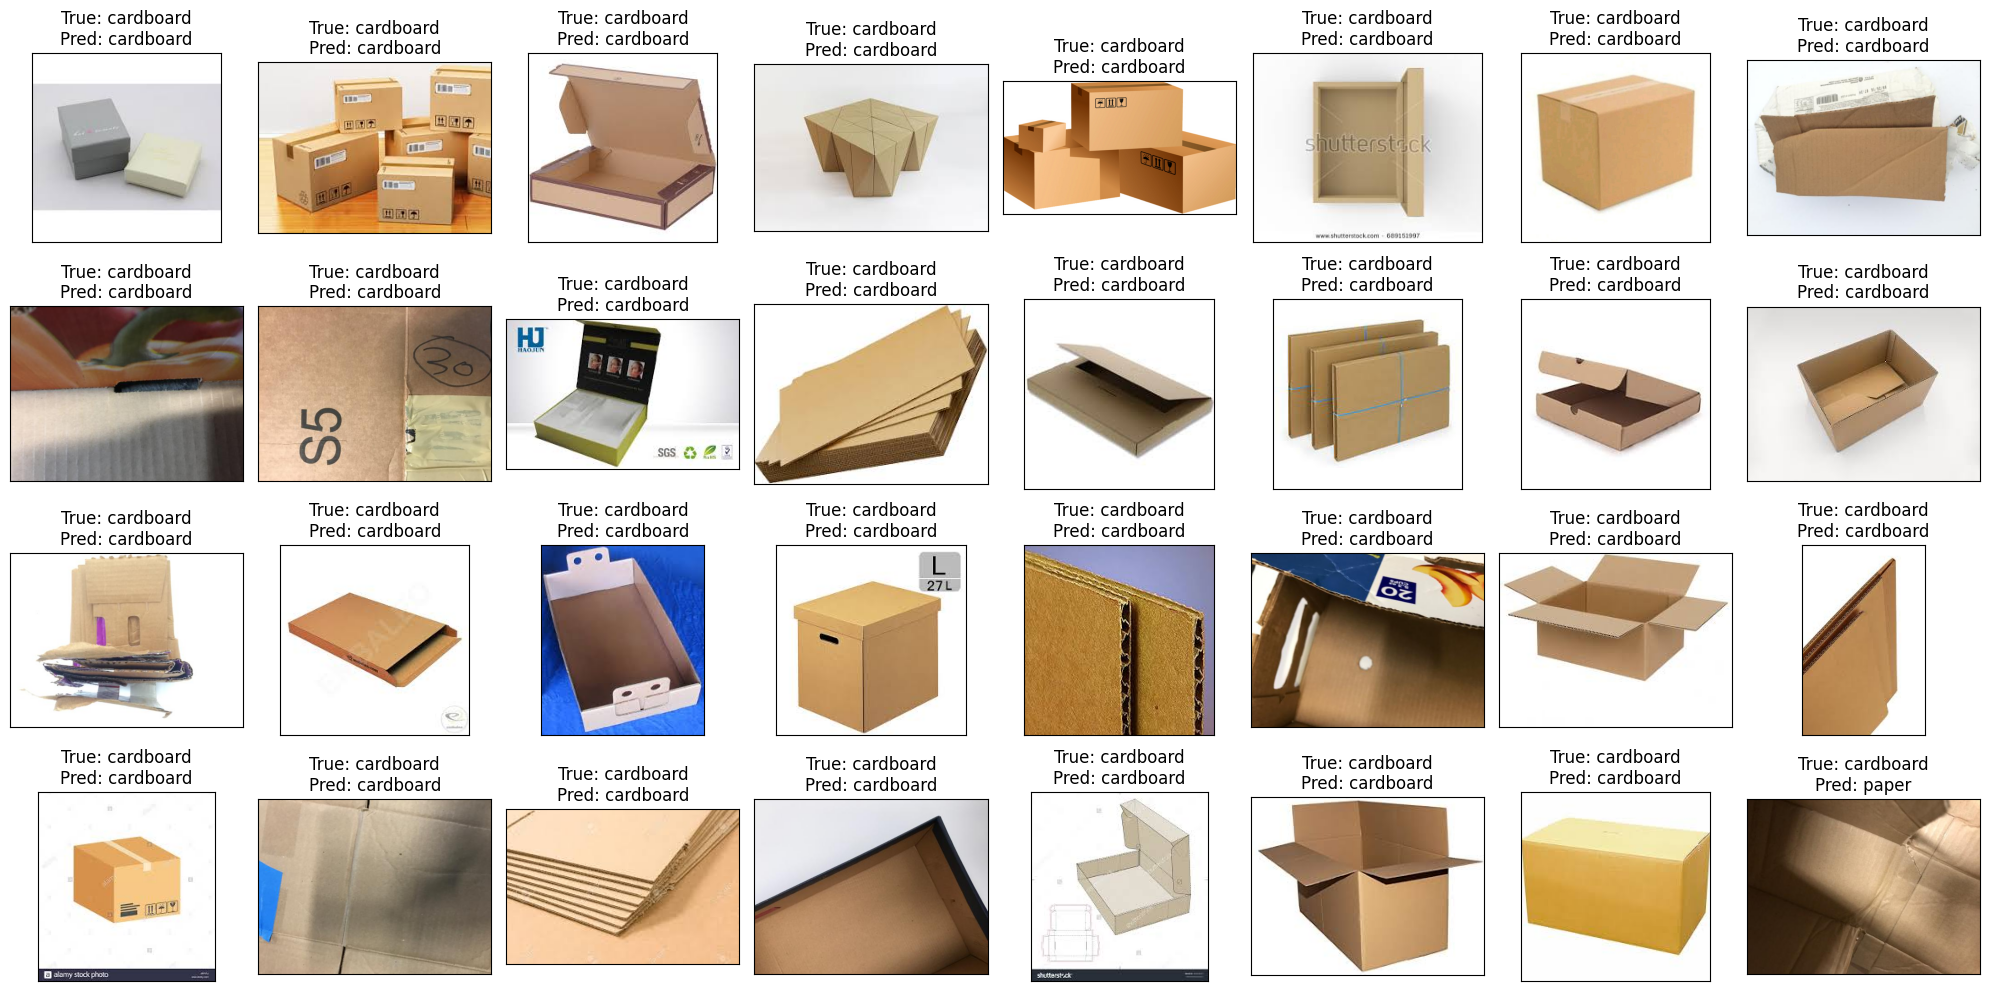

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Pastikan model telah diinisialisasi dan dilatih
# test_generator sudah diinisialisasi sebelumnya

# Lakukan prediksi pada data pengujian
test_data.reset()  # Reset the generator to make predictions from the start
predictions = model.predict(test_data, steps=test_data.samples // test_data.batch_size + 1, verbose=1)

# Ambil label sebenarnya dari generator
true_labels = test_data.classes

# Ambil label prediksi
predicted_labels = np.argmax(predictions, axis=1)

# Ambil beberapa gambar dari dataset pengujian
test_data.reset()
images, _ = next(test_data)
image_paths = test_data.filepaths[:32]  # Misalnya, ambil 32 gambar pertama

# Konversi dict_keys ke list untuk indexing
class_names = list(test_data.class_indices.keys())

# Visualisasikan gambar dengan label sebenarnya dan prediksi
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_paths[i])
    ax.imshow(img)
    true_label = class_names[true_labels[i]]
    predicted_label = class_names[predicted_labels[i]]
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()


## **Uji Coba Model**

Saving Untitled.jpeg to Untitled (1).jpeg
1/1 [==============================] - 1s 1s/step


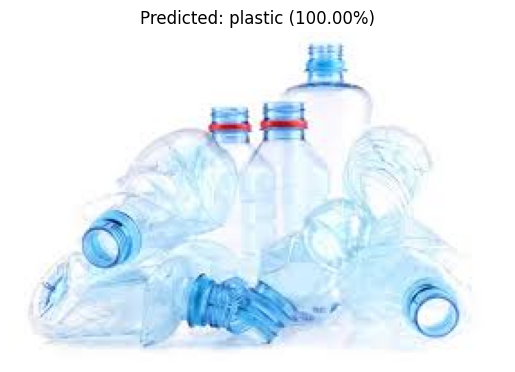

In [63]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import json

# Load the trained model
model = load_model('/content/drive/MyDrive/Garbage classification/H5/model_mobilenetv2_fine_tuned.h5')

# Define the class indices (you can get this from your train_data)
# Example: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
class_indices = train_data.class_indices

# Function to preprocess and predict the class of an image
def predict_image(img_path, model, class_indices):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale to [0, 1]

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_index)]

    return predicted_class, predictions

# Function to display the image and the prediction
def display_prediction(img_path, predicted_class, predictions):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({np.max(predictions)*100:.2f}%)")
    plt.show()

# Upload an image from the user
uploaded = files.upload()

for img_path in uploaded.keys():
    predicted_class, predictions = predict_image(img_path, model, class_indices)
    display_prediction(img_path, predicted_class, predictions)


Saving 2.jpeg to 2.jpeg
1/1 [==============================] - 1s 1s/step


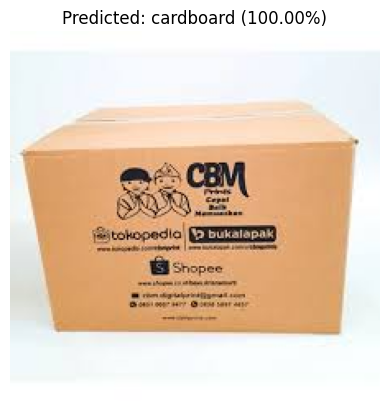

In [65]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import json

# Load the trained model
model = load_model('/content/drive/MyDrive/Garbage classification/H5/model_mobilenetv2_fine_tuned.h5')

# Define the class indices (you can get this from your train_data)
# Example: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
class_indices = train_data.class_indices

# Function to preprocess and predict the class of an image
def predict_image(img_path, model, class_indices):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale to [0, 1]

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_index)]

    return predicted_class, predictions

# Function to display the image and the prediction
def display_prediction(img_path, predicted_class, predictions):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({np.max(predictions)*100:.2f}%)")
    plt.show()

# Upload an image from the user
uploaded = files.upload()

for img_path in uploaded.keys():
    predicted_class, predictions = predict_image(img_path, model, class_indices)
    display_prediction(img_path, predicted_class, predictions)

## **Deploy JSON dan BIN**

#### Savemodel

In [66]:
from google.colab import files
MODEL_BASE_PATH = "/content/sample_data"
PROJECT_NAME = "model"
SAVE_MODEL_NAME = "model_mobilenetv2.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)
files.download(save_model_path)

Saving Model At /content/sample_data/model/model_mobilenetv2.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Install Tfjs sebelum Convert JSON dan BIN

In [67]:
!pip3 install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 636.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
   

#### Convert JSON dan BIN

In [1]:
!cd /content/sample_data/model/
!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model /content/sample_data/model/model_mobilenetv2.h5 /content/sample_data/model

2024-06-09 15:34:08.833014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 15:34:11.423896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!zip -r /content/sample_data/model/tfjs.zip  /content/sample_data/model

  adding: content/sample_data/model/ (stored 0%)
  adding: content/sample_data/model/model_mobilenetv2.h5 (deflated 9%)
  adding: content/sample_data/model/model.json (deflated 96%)
  adding: content/sample_data/model/group1-shard2of4.bin (deflated 7%)
  adding: content/sample_data/model/group1-shard3of4.bin (deflated 7%)
  adding: content/sample_data/model/group1-shard1of4.bin (deflated 7%)
  adding: content/sample_data/model/group1-shard4of4.bin (deflated 7%)


## **NB: Cek Jumlah Data disetiap class**

Jumlah data asli

Jumlah gambar di setiap kelas pada direktori utama:
{'cardboard': 513, 'glass': 514, 'metal': 512, 'paper': 514, 'plastic': 514}


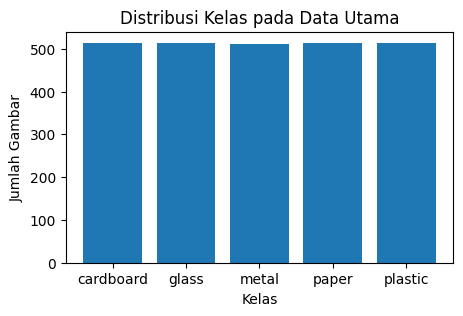

In [36]:
import os
import matplotlib.pyplot as plt

# Direktori untuk dataset
base_dir = '/content/drive/MyDrive/Garbage classification'

# Daftar kelas
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

def count_images(directory, classes):
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Hitung jumlah gambar di setiap kelas pada direktori utama
class_counts = count_images(base_dir, classes)

print("Jumlah gambar di setiap kelas pada direktori utama:")
print(class_counts)

# Visualisasi distribusi kelas
def plot_class_distribution(counts, title):
    plt.figure(figsize=(5,3))
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.show()

plot_class_distribution(class_counts, 'Distribusi Kelas pada Data Utama')


Jumlah data yang sudah di split

In [44]:
import os

# Direktori untuk dataset
base_dir = '/content/drive/MyDrive/Garbage classification'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Daftar kelas
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

def count_images(directory, classes):
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Hitung jumlah gambar di setiap kelas untuk train, validation, dan test directories
train_counts = count_images(train_dir, classes)
val_counts = count_images(validation_dir, classes)
test_counts = count_images(test_dir, classes)

print("Jumlah gambar di setiap kelas pada train directory:")
print(train_counts)
print("\nJumlah gambar di setiap kelas pada validation directory:")
print(val_counts)
print("\nJumlah gambar di setiap kelas pada test directory:")
print(test_counts)


Jumlah gambar di setiap kelas pada train directory:
{'cardboard': 359, 'glass': 407, 'metal': 403, 'paper': 364, 'plastic': 412}

Jumlah gambar di setiap kelas pada validation directory:
{'cardboard': 162, 'glass': 169, 'metal': 164, 'paper': 160, 'plastic': 167}

Jumlah gambar di setiap kelas pada test directory:
{'cardboard': 158, 'glass': 168, 'metal': 169, 'paper': 157, 'plastic': 171}
